In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import mapply
import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from ruzicka.test_metrics import minmax

In [2]:
%load_ext rpy2.ipython

In [3]:
stops_tidy = pd.read_csv("../data/arist_corpus.csv", index_col=0)
stops_tidy.loc[stops_tidy.Work == "Rhet1", "Work"] = "Rhet"
stops_tidy = stops_tidy[~stops_tidy.Work.isin(["1", "2", "4", "5"])]
feat_cols = stops_tidy.columns[4:]
stops_tidy

,Translator,Chunk,Work,Author,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,duplici autem virtute existente hac quidem int...,EthV,Aristoteles,0.000000,0.062338,0.685717,0.0,0.0,0.0,...,0.207793,0.000000,0.0,0.000000,0.207793,0.041559,0.0,0.0,0.145455,0.0
1,Bur,malicia autem contrarium fiet autem nobis et e...,EthV,Aristoteles,0.000000,0.049793,0.813285,0.0,0.0,0.0,...,0.165977,0.000000,0.0,0.000000,0.016598,0.066391,0.0,0.0,0.066391,0.0
2,Bur,bene habentibus operis quoniam neque auferendu...,EthV,Aristoteles,0.000000,0.000000,0.896433,0.0,0.0,0.0,...,0.034478,0.000000,0.0,0.000000,0.091942,0.011493,0.0,0.0,0.045971,0.0
3,Bur,et medietas amicicia qui superhabundat autem q...,EthV,Aristoteles,0.000000,0.064567,0.774798,0.0,0.0,0.0,...,0.096850,0.000000,0.0,0.000000,0.080708,0.064567,0.0,0.0,0.032283,0.0
4,Bur,iacit volens in salute autem sui ipsius et rel...,EthV,Aristoteles,0.000000,0.150855,0.822845,0.0,0.0,0.0,...,0.013714,0.000000,0.0,0.000000,0.095999,0.123427,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,Anon,palam nec enim impar infinitus est nec par gen...,Metaph,Aristoteles,0.025294,0.328824,0.227648,0.0,0.0,0.0,...,0.126471,0.075883,0.0,0.075883,0.430001,0.000000,0.0,0.0,0.455295,0.0
1207,Anon,aut non quare eadem accident et sic aut enim n...,Metaph,Aristoteles,0.000000,0.298142,0.238514,0.0,0.0,0.0,...,0.089443,0.000000,0.0,0.000000,0.268328,0.000000,0.0,0.0,0.566471,0.0
1208,Anon,quidem potentia illud vero actu ergo potentia ...,Metaph,Aristoteles,0.000000,0.380143,0.253429,0.0,0.0,0.0,...,0.050686,0.000000,0.0,0.025343,0.456172,0.000000,0.0,0.0,0.481514,0.0
1209,Anon,tempori non finis est non etiam erit sempitern...,Metaph,Aristoteles,0.030331,0.242647,0.242647,0.0,0.0,0.0,...,0.060662,0.060662,0.0,0.000000,0.121324,0.000000,0.0,0.0,0.454963,0.0


In [4]:
def balanced_subsample(
    y, size=None, rng: np.random.Generator = np.random.default_rng()
):
    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = rng.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample


def bootstrap_imposters(
    test_vec: NDArray[float],
    X: NDArray[NDArray[float]],
    y: NDArray[int],
    cand_idx: int,
    n: int,
    pct: float,
    dist_fn: Callable[[NDArray[float], NDArray[float]], float],
    method: str = "random",
    rng: np.random.Generator = np.random.default_rng(),
    balance: bool = False,
) -> list[float]:
    # X at the row indices where y matches the condition
    candidates = X[(y == cand_idx).nonzero()]
    others = X[(y != cand_idx).nonzero()]
    differences: list[float] = []
    cand_samps: NDArray[float] = []
    other_samps: NDArray[float] = []
    pdy = pd.Series(y)
    if method == "random":
        # choose n random row indices with replacement, all columns. This will
        # still work if n > num_candidates because it will oversample.
        cand_samps = candidates[rng.choice(candidates.shape[0], n, replace=True), :]
        other_samps = others[rng.choice(others.shape[0], n, replace=True), :]

    # At each bootstrap iteration we choose a different feature subset
    for i in range(n * 2):
        if balance:
            # Balances the sample down to the least abundant class
            # In practice, less useful than you'd think.
            ss = balanced_subsample(pdy, rng=rng)  # indices into y
            candidates = X[np.where(y[ss] == cand_idx)]
            others = X[np.where(y[ss] != cand_idx)]
        try:
            # This try is to catch subsamples from sparse data where some column
            # subsets are just empty and so the distance metrics yield divzero.
            # We try for n*2 iterations, returning early when we have n and
            # raising if we don't get there.

            # from 1d vectors, choose (pct * width_of_X) random column indices (no
            # replacement)
            ridx = rng.choice(X.shape[1], int(X.shape[1] * pct), replace=False)

            # compare the test vector to one in-sample and one outsample (with
            # bootstrap columns), then record the difference of distances
            if method == "random":
                in_dist = dist_fn(test_vec[ridx], cand_samps[i][ridx])
                out_dist = dist_fn(test_vec[ridx], other_samps[i][ridx])
                differences.append(out_dist - in_dist)

            # compare the test vector to the closest in-sample and out-sample, then
            # record the difference of distances (like vanilla Kestemont GI)
            elif method == "closest":
                in_dists = [
                    dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
                ]
                out_dists = [
                    dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
                ]
                differences.append(min(out_dists) - min(in_dists))

            # compare the test vector to the closest in-sample and out-sample, then
            # record the scaled difference of distances for the smallest 3 (like
            # Kestemont GI with Eder Boostrap Consensus Tree stye ranking)
            elif method == "ranked":
                in_dists = [
                    dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
                ]
                out_dists = [
                    dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
                ]

                # faster than sorting and slicing
                top_in = heapq.nsmallest(3, in_dists)
                top_out = heapq.nsmallest(3, out_dists)
                d = 0
                for nn in range(3):
                    # smallest distances are unscaled, seccond is halved, etc
                    d += (top_out[nn] - top_in[nn]) / (nn + 1)
                differences.append(d)
            else:
                raise ValueError(
                    f"Unsupported method {method}, valid are: random, closest, ranked"
                )
        except ZeroDivisionError:
            continue
        if len(differences) >= n:
            return differences
    raise ValueError("Too many ZeroDivisionErrors. Data too sparse?")

In [5]:
problems = (
    stops_tidy[stops_tidy.Work.str.startswith("Rhet")].reset_index(drop=True).copy()
)
problems

,Translator,Chunk,Work,Author,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Wil,rethorica assecutiva dialetice est ambe enim d...,Rhet,Aristoteles,0.0,0.319732,0.601848,0.000000,0.0,0.000000,...,0.037616,0.112847,0.0,0.000000,0.150462,0.150462,0.000000,0.0,0.018808,0.0
1,Wil,et eos qui non possunt recipere sanitatem tame...,Rhet,Aristoteles,0.0,0.207550,0.756074,0.000000,0.0,0.014825,...,0.044475,0.088950,0.0,0.014825,0.103775,0.000000,0.029650,0.0,0.029650,0.0
2,Wil,sunt pauca quidem necessaria ex quibus rethori...,Rhet,Aristoteles,0.0,0.131647,0.750390,0.000000,0.0,0.000000,...,0.039494,0.026329,0.0,0.039494,0.236965,0.039494,0.039494,0.0,0.026329,0.0
3,Wil,puta qui diiudicatur quomodo non fuerit factum...,Rhet,Aristoteles,0.0,0.410564,0.759544,0.000000,0.0,0.000000,...,0.000000,0.020528,0.0,0.000000,0.102641,0.143697,0.000000,0.0,0.000000,0.0
4,Wil,quare palam quod ad legislationem quidem terre...,Rhet,Aristoteles,0.0,0.448704,0.769207,0.000000,0.0,0.000000,...,0.048075,0.032050,0.0,0.000000,0.096151,0.048075,0.000000,0.0,0.016025,0.0
5,Wil,utique bene fortunatus permanebit est autem qu...,Rhet,Aristoteles,0.0,0.277868,0.719189,0.000000,0.0,0.000000,...,0.016345,0.016345,0.0,0.016345,0.196142,0.065381,0.032690,0.0,0.016345,0.0
6,Wil,omnes aut multi aut similes aut que minores di...,Rhet,Aristoteles,0.0,0.386769,0.520651,0.000000,0.0,0.000000,...,0.014876,0.014876,0.0,0.000000,0.089254,0.089254,0.000000,0.0,0.014876,0.0
7,Wil,voluntate cum enim velint existit magis qui fi...,Rhet,Aristoteles,0.0,0.216179,0.602213,0.000000,0.0,0.000000,...,0.015441,0.000000,0.0,0.000000,0.046324,0.108090,0.030883,0.0,0.015441,0.0
8,Wil,virtutis iustitia et fortitudo temperantia mag...,Rhet,Aristoteles,0.0,0.168852,0.731693,0.000000,0.0,0.000000,...,0.056284,0.037523,0.0,0.056284,0.093807,0.093807,0.018761,0.0,0.000000,0.0
9,Wil,prohibens hoc autem non prohibens transponatur...,Rhet,Aristoteles,0.0,0.291256,0.823115,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.063317,0.050653,0.000000,0.0,0.025327,0.0


In [6]:
problems["Compound"] = problems.apply(
    lambda r: f"{r.Translator}{r.Work}{r.name}", axis=1
)

In [7]:
comparison = (
    stops_tidy[~stops_tidy.Work.str.startswith("Rhet")].reset_index(drop=True).copy()
)
comparison

,Translator,Chunk,Work,Author,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,duplici autem virtute existente hac quidem int...,EthV,Aristoteles,0.000000,0.062338,0.685717,0.0,0.0,0.0,...,0.207793,0.000000,0.0,0.000000,0.207793,0.041559,0.0,0.0,0.145455,0.0
1,Bur,malicia autem contrarium fiet autem nobis et e...,EthV,Aristoteles,0.000000,0.049793,0.813285,0.0,0.0,0.0,...,0.165977,0.000000,0.0,0.000000,0.016598,0.066391,0.0,0.0,0.066391,0.0
2,Bur,bene habentibus operis quoniam neque auferendu...,EthV,Aristoteles,0.000000,0.000000,0.896433,0.0,0.0,0.0,...,0.034478,0.000000,0.0,0.000000,0.091942,0.011493,0.0,0.0,0.045971,0.0
3,Bur,et medietas amicicia qui superhabundat autem q...,EthV,Aristoteles,0.000000,0.064567,0.774798,0.0,0.0,0.0,...,0.096850,0.000000,0.0,0.000000,0.080708,0.064567,0.0,0.0,0.032283,0.0
4,Bur,iacit volens in salute autem sui ipsius et rel...,EthV,Aristoteles,0.000000,0.150855,0.822845,0.0,0.0,0.0,...,0.013714,0.000000,0.0,0.000000,0.095999,0.123427,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,Anon,palam nec enim impar infinitus est nec par gen...,Metaph,Aristoteles,0.025294,0.328824,0.227648,0.0,0.0,0.0,...,0.126471,0.075883,0.0,0.075883,0.430001,0.000000,0.0,0.0,0.455295,0.0
1178,Anon,aut non quare eadem accident et sic aut enim n...,Metaph,Aristoteles,0.000000,0.298142,0.238514,0.0,0.0,0.0,...,0.089443,0.000000,0.0,0.000000,0.268328,0.000000,0.0,0.0,0.566471,0.0
1179,Anon,quidem potentia illud vero actu ergo potentia ...,Metaph,Aristoteles,0.000000,0.380143,0.253429,0.0,0.0,0.0,...,0.050686,0.000000,0.0,0.025343,0.456172,0.000000,0.0,0.0,0.481514,0.0
1180,Anon,tempori non finis est non etiam erit sempitern...,Metaph,Aristoteles,0.030331,0.242647,0.242647,0.0,0.0,0.0,...,0.060662,0.060662,0.0,0.000000,0.121324,0.000000,0.0,0.0,0.454963,0.0


In [8]:
lenc = LabelEncoder()
labels = lenc.fit_transform(stops_tidy.Translator)

In [9]:
ss = StandardScaler(with_mean=False).fit(stops_tidy[feat_cols])

In [10]:
X = ss.transform(comparison[feat_cols])
y = np.array(lenc.transform(comparison.Translator))

In [11]:
probs_X = ss.transform(problems[feat_cols])
problem_dict = dict(zip(problems.Compound, probs_X))

In [12]:
for i in set(y):
    print(f"Testing against {lenc.inverse_transform([i])[0]}")
    results = {}
    for work, vec in problem_dict.items():
        if not work.startswith("Bar"):
            continue
        bs = bootstrap_imposters(
            vec,
            X,
            y,
            i,
            1000,
            0.35,
            minmax,
            "ranked",
            rng=np.random.default_rng(seed=42),
            balance=False,
        )
        results[work] = bs

    this_df = pd.DataFrame(results)

    s = "Bar"
    for c in this_df.columns[this_df.columns.str.startswith(s)]:
        print(
            f"{c:<15} {100 - sp.stats.percentileofscore(this_df[c], 0):5.2f}  {sp.stats.skew(this_df[c]):5.2f}"
        )
    ms = [
        100 - sp.stats.percentileofscore(this_df[c], 0)
        for c in this_df.columns[this_df.columns.str.startswith(s)]
    ]
    print(f"\nMatch % -- Median: {np.median(ms):5.2f} Std: {np.std(ms):5.2f}")
    skew = [
        sp.stats.skew(this_df[c], 0)
        for c in this_df.columns[this_df.columns.str.startswith(s)]
    ]
    print(f"Skew    -- Mean: {np.median(skew):5.2f} Std: {np.std(skew):5.2f}")

Testing against Anon
BarRhet15       12.40  -0.27
BarRhet16        5.20  -0.02
BarRhet17        1.60  -0.31
BarRhet18        0.30  -0.18
BarRhet19       17.40  -0.53
BarRhet20        7.70  -0.37
BarRhet21       11.60  -0.28
BarRhet22        1.70  -0.25
BarRhet23        1.40  -0.12
BarRhet24       18.60  -0.27
BarRhet25        1.60  -0.36
BarRhet26       15.40  -0.41
BarRhet27        9.00  -0.31
BarRhet28       10.00  -0.41

Match % -- Median:  8.35 Std:  6.12
Skew    -- Mean: -0.30 Std:  0.13
Testing against Arist
BarRhet15        0.10  -0.33
BarRhet16        0.00  -0.15
BarRhet17        0.00  -0.21
BarRhet18        0.00  -0.17
BarRhet19        0.00  -0.29
BarRhet20        0.00  -0.43
BarRhet21        0.00  -0.26
BarRhet22        0.10  -0.07
BarRhet23        0.00  -0.39
BarRhet24        0.00  -0.30
BarRhet25        0.00  -0.47
BarRhet26        0.00  -0.39
BarRhet27        0.00  -0.60
BarRhet28        0.00  -0.35

Match % -- Median:  0.00 Std:  0.03
Skew    -- Mean: -0.31 Std:  0.14
Tes

In [27]:
results = {}
X = ss.transform(comparison[feat_cols])
y = np.array(lenc.transform(comparison.Translator))
for work, vec in problem_dict.items():
    if not work.startswith("Bar"):
        continue
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        lenc.transform(["Bar"])[0],  # type: ignore
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    results[work] = bs

bxx_df = pd.DataFrame(results)

In [28]:
df = bxx_df.melt()

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 3 rows containing non-finite values (stat_density). 



In addition: Warning message:
Removed 3 rows containing non-finite values (stat_density). 


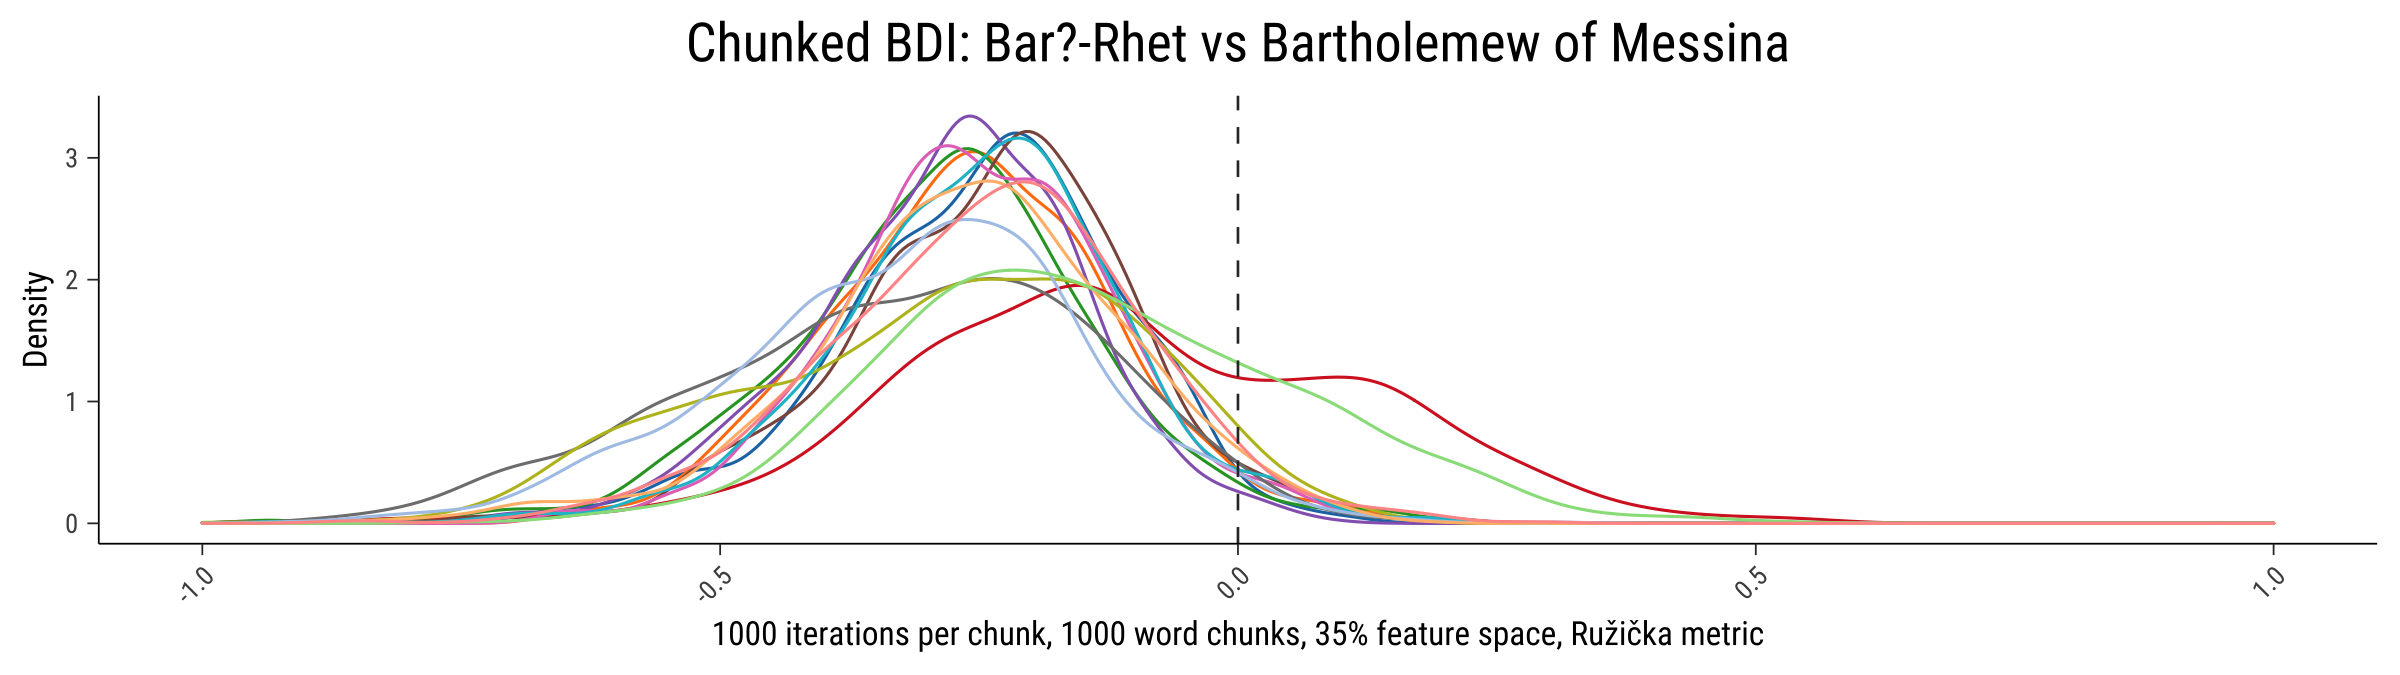

In [31]:
%%R -i df -h 2.25 -w 8 -u in -r 300

library(ggplot2)
library(ggridges)
library(showtext)
library(paletteer)
library(stringr)
library(dplyr)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()


plt <- "ggsci::category20_d3"
bgcol = 'white' 

p <- ggplot(df, aes(value, color=variable)) +
coord_cartesian(clip = "off") +
geom_density(
    size = 0.35, alpha=0.75
) +

scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
xlim(-1,1) +
geom_vline(xintercept=0, size=0.3, color='grey20', linetype='dashed') +
theme_bw() +
xlab("1000 iterations per chunk, 1000 word chunks, 35% feature space, Ružička metric") +
ylab("Density") +
ggtitle("Chunked BDI: Bar?-Rhet vs Bartholemew of Messina") +
theme(
    panel.border = element_blank(),
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="fnt"),
    axis.text.x=element_text(angle = 45, hjust = 1),

)

fn <- "../figures/bdi_bar_paper.png"
ggsave(fn, dpi=300, width=8, height=2.25)

p

In [13]:
results = {}
for work, vec in problem_dict.items():
    if not work.startswith("Wil"):
        continue
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        lenc.transform(["Wil"])[0],  # type: ignore
        1000,
        0.35,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    results[work] = bs

wil_df = pd.DataFrame(results)

In [14]:
s = "Wil"
for c in wil_df.columns[wil_df.columns.str.startswith(s)]:
    print(
        f"{c:<15} {100 - sp.stats.percentileofscore(wil_df[c], 0):5.2f}  {sp.stats.skew(wil_df[c]):5.2f}"
    )
ms = [
    100 - sp.stats.percentileofscore(wil_df[c], 0)
    for c in wil_df.columns[wil_df.columns.str.startswith(s)]
]
print(f"\nMatch % -- Mean: {np.median(ms):5.2f} Std: {np.std(ms):5.2f}")
skew = [
    sp.stats.skew(wil_df[c], 0)
    for c in wil_df.columns[wil_df.columns.str.startswith(s)]
]
print(f"Skew    -- Mean: {np.mean(skew):5.2f} Std: {np.std(skew):5.2f}")

WilRhet0        78.00   0.25
WilRhet1        96.00   0.26
WilRhet2        98.60   0.48
WilRhet3        79.40   0.12
WilRhet4        76.40   0.16
WilRhet5        87.50   0.38
WilRhet6        81.70   0.16
WilRhet7        96.50   0.65
WilRhet8        73.30   0.47
WilRhet9        84.90   0.25
WilRhet10       64.40   0.48
WilRhet11       73.00   0.19
WilRhet12       76.10   0.26
WilRhet13       95.60   0.32
WilRhet14       72.20   0.15

Match % -- Mean: 79.40 Std: 10.19
Skew    -- Mean:  0.31 Std:  0.15


In [22]:
wil_long = wil_df.melt()

In addition: Warning message:
Ignoring unknown parameters: quantile_lines, quantiles 


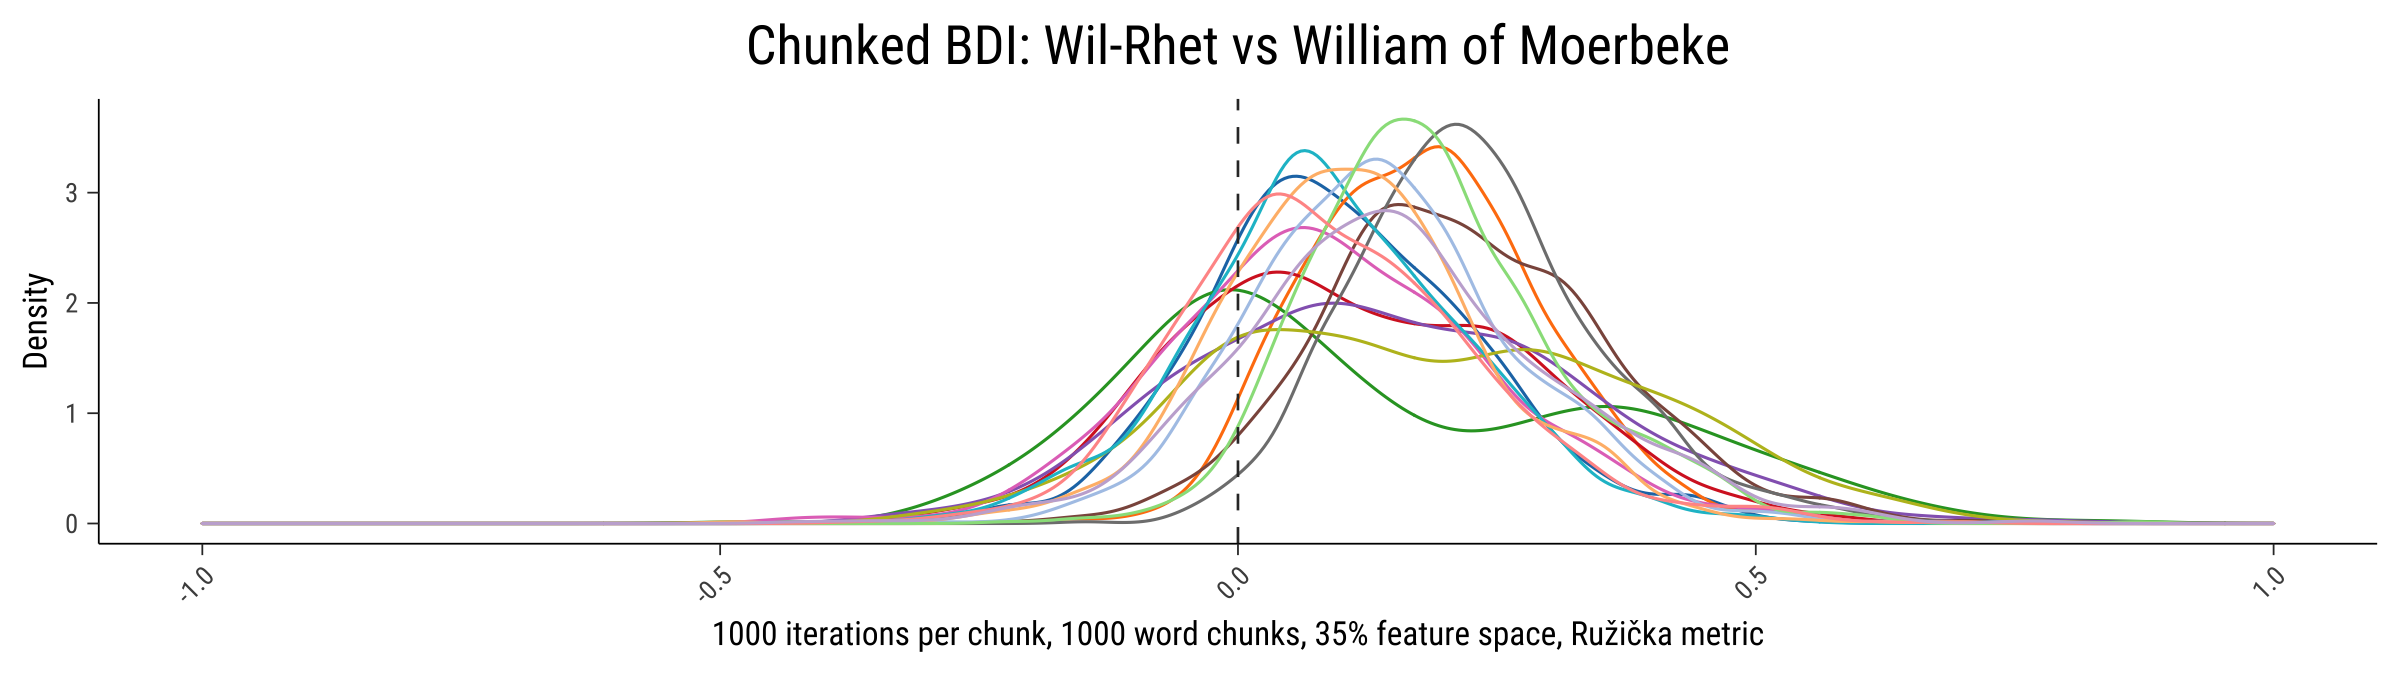

In [23]:
%%R -i wil_long -h 2.25 -w 8 -u in -r 300

library(ggplot2)
library(ggridges)
library(showtext)
library(paletteer)
library(stringr)
library(dplyr)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

df <- wil_long
plt <- "ggsci::category20_d3"
bgcol = 'white'

p <- ggplot(df, aes(value, color=variable)) +
coord_cartesian(clip = "off") +
geom_density(
    size = 0.35, alpha=0.75
) +

scale_color_paletteer_d(plt) +
xlim(-1,1) +
geom_vline(xintercept=0, size=0.3, color='grey20', linetype='dashed') +
theme_bw() +
xlab("1000 iterations per chunk, 1000 word chunks, 35% feature space, Ružička metric") +
ylab("Density") +
ggtitle(expression("Chunked BDI: Wil-Rhet vs William of Moerbeke")) +
theme(
    panel.border = element_blank(),
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=13),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=8, family="fnt"),
    axis.text.x=element_text(angle = 45, hjust = 1),

)

# fn <- "../figures/bdi_wil_paper.png"
# ggsave(fn, dpi=300, width=8, height=2.25)

p

In [19]:
def bs_row_harsh(r, df, X, y):
    # for each row, do not include any row from the same work
    where = np.where((df.Translator == r.Translator) & (df.Work == r.Work))
    bs = bootstrap_imposters(
        X[r.name],
        np.delete(X, where, 0),
        np.delete(y, where),
        lenc.transform([r.Translator])[0],
        1000,
        0.5,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
        balance=False,
    )
    # 'confidence' is 1 - the uncertainty, which we have taken as the
    # probability mass that lies below 0 (runs with imposters closer than
    # candidates), expressed here as percentile
    return 100 - sp.stats.percentileofscore(bs, 0)

In [15]:
full_corpus = stops_tidy.copy().reset_index(drop=True)

In [16]:
X = ss.transform(full_corpus[feat_cols])
y = np.array(lenc.transform(full_corpus.Translator))

In [17]:
mapply.init(n_workers=-1)

In [20]:
full_corpus["Match"] = full_corpus.mapply(
    (lambda row: bs_row_harsh(row, full_corpus, X, y)), axis=1
)

100%|██████████| 12/12 [02:12<00:00, 11.08s/it]


In [32]:
# Pri and Hom are too small
full_corpus = full_corpus[(full_corpus.Work != "Pri")].reset_index(drop=True)
full_corpus = full_corpus[(full_corpus.Work != "Hom")].reset_index(drop=True)
# Use the more informative sigla for the Simplicius works
full_corpus.loc[full_corpus.Work == "3", ["Work"]] = "Adv"
full_corpus.loc[full_corpus.Work == "6", ["Work"]] = "Pyrr"
full_corpus["CompoundWork"] = full_corpus.apply(
    lambda r: f"{r['Translator']}-{r['Work']}", axis=1
)
full_corpus.loc[full_corpus.CompoundWork == "Bar-Rhet", ["CompoundWork"]] = "Bar?-Rhet"

`summarise()` has grouped output by 'Translator'. You can override using the
`.groups` argument.


Picking joint bandwidth of 5.81
In addition: Warning message:
Using alpha for a discrete variable is not advised. 
Picking joint bandwidth of 5.81


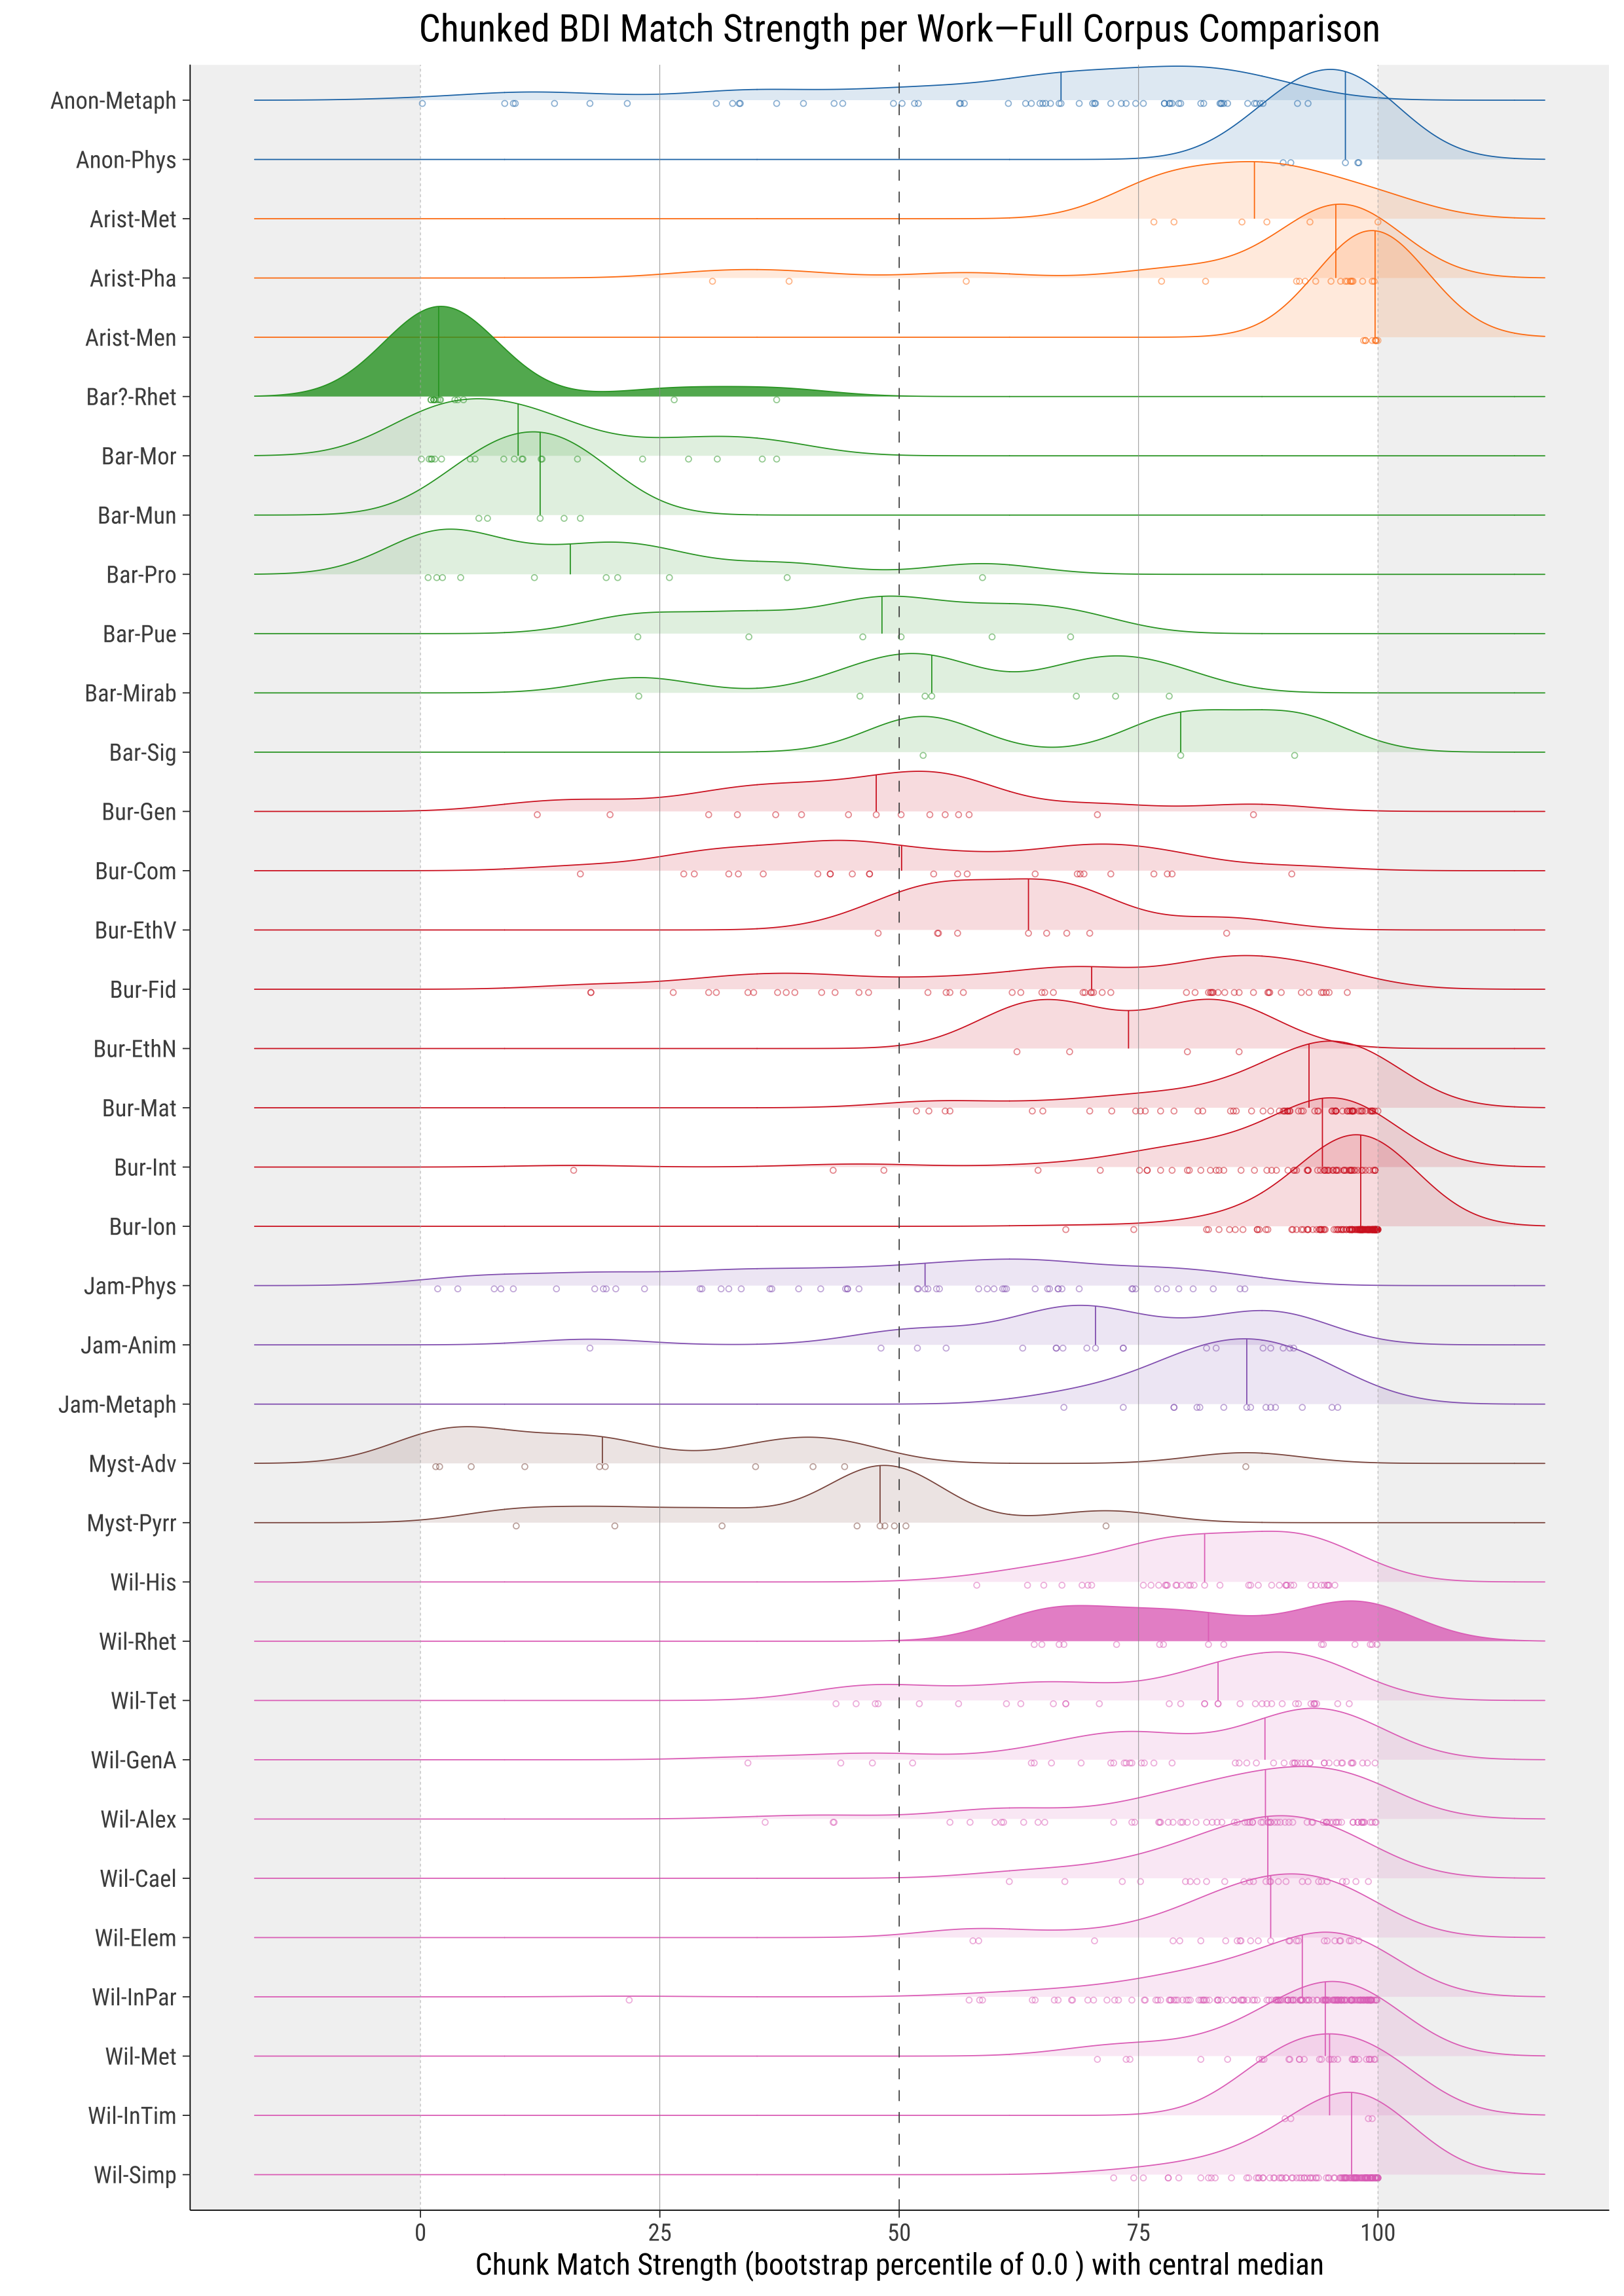

In [33]:
%%R -i full_corpus -h 297 -w 210  -u mm -r 300

library(ggplot2)
library(ggridges)
library(showtext)
library(paletteer)
library(stringr)
library(dplyr)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

df <- full_corpus %>%
    mutate(rhet=str_detect(Work,'Rhet'))

# get ranks by Translator with increasing median confidence
rank_df <- df %>% 
    group_by(Translator,CompoundWork) %>%
    summarise(meanM=median(Match)) %>%
    arrange(Translator,meanM)

# reorder original data with those ranks
df2 <- df %>% mutate(CompoundWork=factor(CompoundWork,levels=rank_df$CompoundWork))

plt <- "ggsci::category10_d3"
bgcol = 'white'
   
p <- ggplot(df2, aes(Match, CompoundWork, fill = Translator, color=Translator)) +
# bands to show where the real data does not exist
geom_rect(xmin=-Inf, xmax=0, ymin=-Inf, ymax=Inf, fill='grey95', alpha=0.25, color=NA) +
geom_rect(xmin=100, xmax=Inf, ymin=-Inf, ymax=Inf, fill='grey95', alpha=0.25, color=NA) +
# points for the rug plot
geom_point(shape=1, size=0.8, stroke=0.3, position = position_nudge(y = -0.055), alpha=0.5) +
ggridges::stat_density_ridges(
    quantile_lines = TRUE, quantiles = 2, 
    aes(alpha = rhet), size = 0.2
) +
# to emphasise the two Rhetoricae
scale_alpha_discrete(range=c(0.15,0.8)) +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
scale_x_continuous(breaks=c(0,25,50,75,100)) +
# Alphabetical top descending
scale_y_discrete(limits=rev) +

geom_vline(xintercept=0, size=0.1, color='grey70', linetype='11') +
geom_vline(xintercept=25, size=0.1, color='grey60') +
geom_vline(xintercept=50, size=0.2, color='grey30', linetype='dashed') +
geom_vline(xintercept=75, size=0.1, color='grey60') +
geom_vline(xintercept=100, size=0.1, color='grey70', linetype='11') +

theme_bw() +
xlab("Chunk Match Strength (bootstrap percentile of 0.0 ) with central median") +
ylab("") +
ggtitle("Chunked BDI Match Strength per Work—Full Corpus Comparison") +
theme(
    panel.border = element_blank(),
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol),
    legend.position='none',
    plot.title = element_text(hjust = 0.5, size=14),
    axis.line.x=element_line(size=0.2),
    axis.line.y=element_line(size=0.2),
    axis.ticks.x=element_line(size=0.2),
    axis.ticks.y=element_line(size=0.2),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text=element_text(size=11, family="fnt"),
)

fn <- "../figures/bdi_all_paper.png"
ggsave(fn, dpi=300, width=210, height=297, units='mm')

p